# <font color=#2e86c1> $R_{1\rho}$ simulation and analysis</font> 

The $R_{1\rho}$ experiment is a useful experiment for characterizing slow ($\mu$s/ms) motion in solid-state NMR. The pulse sequence involves flipping magnetization of a spin (often $^{15}$N or $^{13}$C, CP-based excitation also possible) to the x-axis, spin-locking that magnetization, and observing its decay (again, CP-transfer back to $^1$H may be useful).

<img src="R1p_sequence.png" alt="sequence" width=300>

This experiment is sensitive to both reorientational motion of anisotropic tensors (dipole/CSA) and changes to the isotropic chemical shift. In the first part of this exercise, we will use simulation to explore the relaxation behavior of the $R_{1\rho}$ experiment, and in the second part, we will fit $R_{1\rho}$ measurements to extract dynamics parameters from a data set.

## Part 1: Simulating $R_{1\rho}$

### Setup

In [1]:
# Make sure SLEEPY is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !pip install sleepy-nmr
elif 'USER' in os.environ and os.environ['USER']=='jovyan': #Binder
    !pip install sleepy-nmr
else:
    os.chdir('../../..')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

### Build the spin system
Setup contains similar parameters as SIMPSON, with an important distinction: we set up the system
twice with different Euler angles, to introduce reorientational motion, and with a different chemical shift, to introduce chemical exchange.

In [26]:
# H-N dipole coupling for 0.102 nm
deltaHN=sl.Tools.dipole_coupling(.102,'1H','15N')
# Typical protein backbone 15N CSA
deltaCSA=113
# Change in the 15N chemical shift
DelCS=10
# Hop angle
hop_angle=25

# Magnetic field (MHz), Nuclei, spinning rate, powder-average quality
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2)
# H–N dipole coupling, i0: spin 0, i1: spin 1, delta: anisotropy of interaction
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
# 15N CSA, i: spin, delta: anisotropy in ppm, euler_d: Euler angles in degrees
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])
# 15N chemical shift, i: spin, CS: chemical shift in ppm
ex0.set_inter('CS',i=0,ppm=DelCS/2)

# Copy ex0 (links copies, ensures matching experimental settings)
ex1=ex0.copy()
# As above, plus tilt the dipole coupling by the hop_angle
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
# As above, plus add a second set of Euler angles with the hop angle
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])
# As above, but change CS
_=ex1.set_inter('CS',i=0,ppm=-DelCS/2)

### Couple systems into a Liouvillian, generate a pulse sequence

In [31]:
# Correlation time of the exchange
tc=1e-5
# Population of state 1
p1=0.5
# Spin-lock strength
v1=35000

# Create a Liouvillian with two systems in exchange
L=sl.Liouvillian(ex0,ex1)
# Add an exchange matrix betweent the two systems
L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)

# Create a pulse sequence object
seq=L.Sequence()
# Add a spin-locking field 
# For continuous field, we can just specify power
# but including a time axis with varying power, phase, and offset is also possible
_=seq.add_channel('15N',v1=v1)
# Note that the default sequence length is 1 rotor period if time axis not given

### Create a density matrix, propagate

In [62]:
# Initial state of density matrix, detection matrix
rho=sl.Rho(rho0=ex0.Op[0].x@ex0.Op[1].beta,detect='15Nx')
# Propagate for 100 ms (n is number of steps, use int() to get an integer)
_=rho.DetProp(seq,n=int(0.1*ex0.vr)) 

### Plot the results

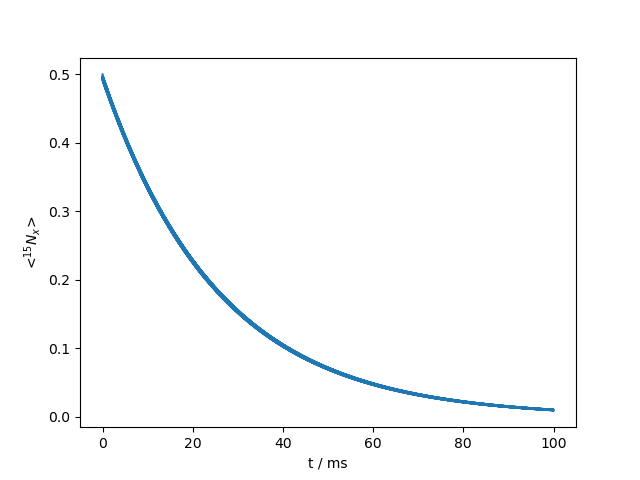

In [63]:
_=rho.plot(pwd_index=40)

### Create functions for faster setup

In [34]:
def R1pU(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1):
    ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=2)
    ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
    ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])
    ex0.set_inter('CS',i=0,ppm=DelCS/2)
    
    ex1=ex0.copy()
    ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
    ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])
    ex1.set_inter('CS',i=0,ppm=-DelCS/2)

    L=sl.Liouvillian(ex0,ex1)
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    seq=L.Sequence()
    seq.add_channel('15N',v1=v1)
    return seq.U()

def R1p_rho(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1):
    U=R1pU(tc=tc,p1=p1,hop_angle=hop_angle,DelCS=DelCS,v1=v1)
    rho=sl.Rho(rho0='15Nx',detect='15Nx')
    rho.DetProp(U**int(U.expsys.vr/1000),n=100)
    return rho

### For v1=35000 Hz, what has a bigger influence, the CS change or the hopping?

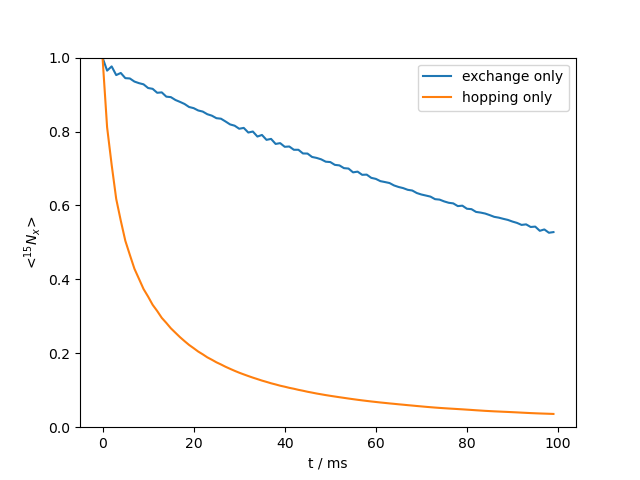

In [35]:
# First, just remove hopping
rho0=R1p_rho(hop_angle=0)
# Plot the result (save the axis)
ax=rho0.plot(label='exchange only')
# Second, just remove exchange
rho1=R1p_rho(DelCS=0)
rho1.plot(ax=ax,label='hopping only')
ax.set_ylim([0,1])
ax.legend()

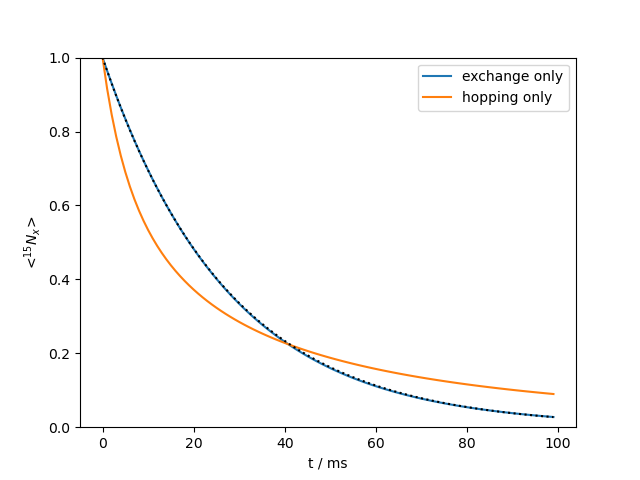

In [70]:
rho0=R1p_rho(v1=1000,hop_angle=0)
ax=rho0.plot(label='exchange only')
rho1=R1p_rho(v1=1000,DelCS=0)
rho1.plot(ax=ax,label='hopping only')
ax.set_ylim([0,1])
ax.legend()

In the above plot, exchange-only relaxation is in fact monoexponential, but the hopping only plot is not. Why not? (there are two reasons)
```{dropdown} Answer
1) Different orientations of the dipole coupling yield different relaxation rates
2) The $H^\alpha$ and $H^\beta$ substates yield different relaxation rates where CSA and dipole relaxation are additive and subtractive, respectively. See hidden cell below, which plots a single orientation, and separates the two substates, which gives approximately monoexponential decay (oscillation can still occur, but indeed the decaying components should be purely monoexponential)
```

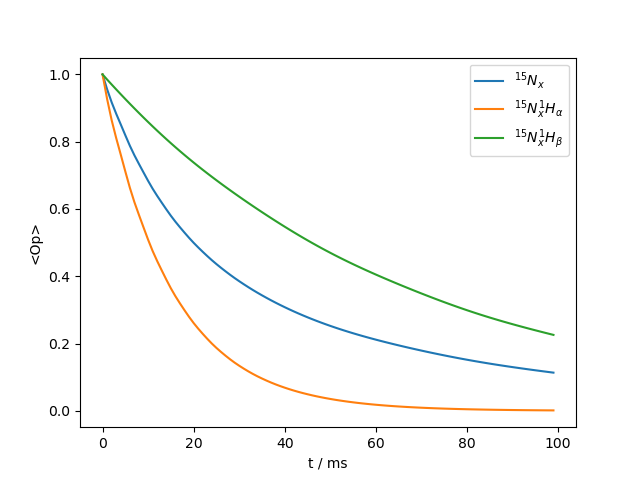

In [90]:
#We create a powder average, and then grab just one element from it by indexing
pwdavg=sl.PowderAvg('rep144')[20]
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=pwdavg)
ex0.set_inter('dipole',i0=0,i1=1,delta=deltaHN)
ex0.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[0,23,120])
ex0.set_inter('CS',i=0,ppm=DelCS/2)

ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=deltaHN,euler_d=[0,hop_angle,0])
ex1.set_inter('CSA',i=0,delta=deltaCSA,euler_d=[[0,23,120],[0,hop_angle,0]])
ex1.set_inter('CS',i=0,ppm=-DelCS/2)

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=1e-4,p1=p1)

seq=L.Sequence()
seq.add_channel('15N',v1=35000)

U=seq.U()**(ex0.vr//1000)  #1 ms timestep

#Expsys.Op contains the operators for each spin
#We can create arbitrary detection operators with these
NxHalpha=ex0.Op[0].x@ex0.Op[1].alpha    
NxHbeta=ex0.Op[0].x@ex0.Op[1].beta

rho=sl.Rho(rho0='15Nx',detect=['15Nx',NxHalpha,NxHbeta]).DetProp(U,n=100)
ax=rho.plot(det_num=0,label=r'$^{15}N_x$')
rho.plot(det_num=1,label=r'$^{15}N_x^1H_\alpha$',ax=ax)
rho.plot(det_num=2,label=r'$^{15}N_x^1H_\beta$',ax=ax)
_=ax.legend()

### Sweep field strength

In [42]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
v10=np.linspace(0,50000,26)
v10[0]=1000
R1p=[]
for v1 in v10:
    rho.clear()
    R1p.append(rho.extract_decay_rates(R1pU(tc=1e-5,v1=v1)))
    if np.mod(v1,10000)==0:print(v1)

10000.0
20000.0
30000.0
40000.0
50000.0


(0.0, 436.04896712859255)

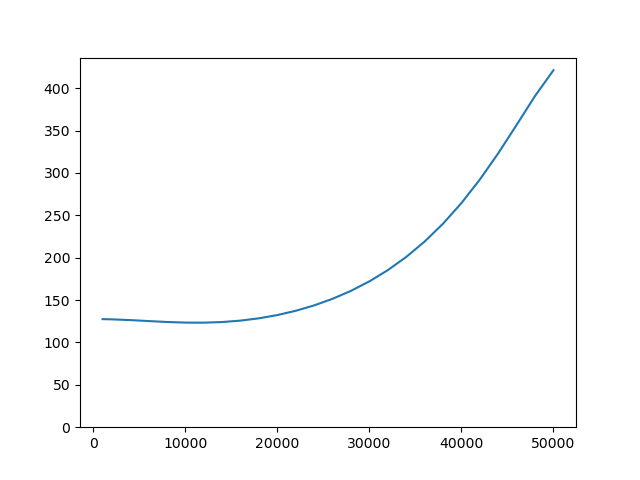

In [43]:
ax=plt.subplots()[1]
ax.plot(v10,R1p)
ax.set_ylim([0,ax.get_ylim()[1]])

In [44]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
v10=np.linspace(0,50000,26)
v10[0]=1000
R1p_hop=[]
for v1 in v10:
    rho.clear()
    R1p_hop.append(rho.extract_decay_rates(R1pU(tc=1e-5,v1=v1,DelCS=0)))
    if np.mod(v1,10000)==0:print(v1)

10000.0
20000.0
30000.0
40000.0
50000.0


In [45]:
rho=sl.Rho(rho0='15Nx',detect='15Nx')
v10=np.linspace(0,50000,26)
v10[0]=1000
R1p_ex=[]
for v1 in v10:
    rho.clear()
    R1p_ex.append(rho.extract_decay_rates(R1pU(tc=1e-5,v1=v1,hop_angle=0)))
    if np.mod(v1,10000)==0:print(v1)

10000.0
20000.0
30000.0
40000.0
50000.0


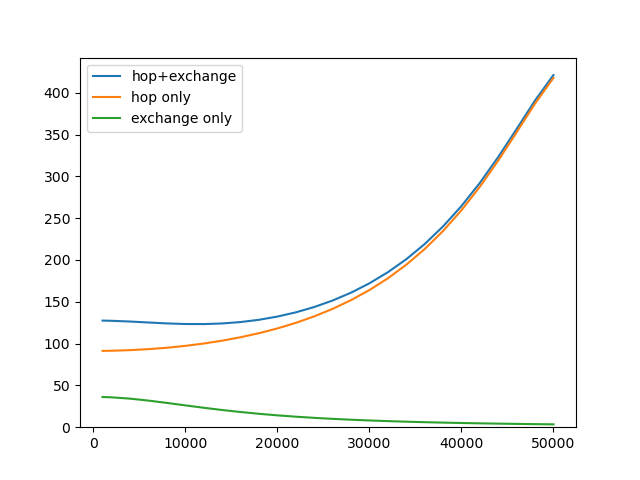

In [46]:
ax=plt.subplots()[1]
ax.plot(v10,R1p,label='hop+exchange')
ax.plot(v10,R1p_hop,label='hop only')
ax.plot(v10,R1p_ex,label='exchange only')
ax.set_ylim([0,ax.get_ylim()[1]])
ax.legend()